# DL- Predicción de edad 

## Consideraciones del proyecto

A la cadena de supermercados Good Seed le gustaría explorar si la ciencia de los datos puede ayudarle a cumplir con las leyes sobre el alcohol, al asegurarse de no vender alcohol a personas menores de edad. Te piden que hagas esa evaluación, así que, cuando te pongas a trabajar, ten en cuenta lo siguiente:

* Las tiendas están equipadas con cámaras en el área de pago, las cuales se activan cuando una persona está comprando alcohol.
* Los métodos de visión artificial se pueden usar para determinar la edad de una persona a partir de una foto.
* La tarea, entonces, es construir y evaluar un modelo para verificar la edad de las personas.

**IMPORTACIONES**

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, Rescaling
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carga de Datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

## Carga de Datos CSV

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

<Axes: xlabel='real_age', ylabel='Count'>

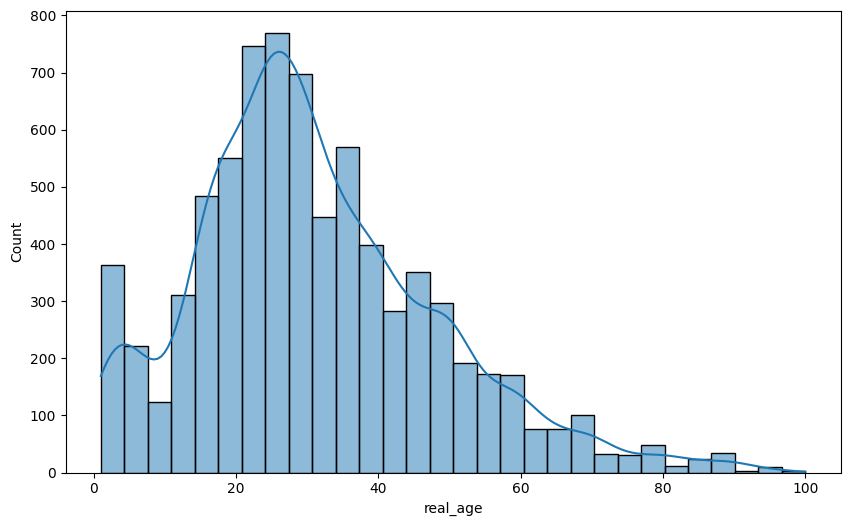

In [2]:
# Cargar el DataFrame completo
df = pd.read_csv('/content/drive/MyDrive/proyecto17/labels.csv')

# Explorar el DataFrame
display(df.head(10))
display(df.info())
# Grafica exploratoria de edades

plt.figure(figsize=(10,6))
sns.histplot(df['real_age'], bins=30, kde=True)

Me doy cuenta que existe una distribución muy definida entre la cantidad y la edad de las imágenes de las personas. Para hacer el modelo, necesito separar mi base de datos en 3 DataFrames (entrenamiento, validación y prueba), e idealmente, debe exisitir un balance de esta clase en estas divisiones, por lo que se definirán ciertos bins para equilibrar el split.

In [3]:
# Definir bins para categorizar edades al hacer el split
bins = [0, 12, 18, 25, 35, 45, 55, 65, 75, 85, 100, 120]
df['age_bin'] = pd.cut(df['real_age'], bins=bins, right=False, include_lowest=True)

# Filtro de bins con muestra mínima de 2 (había solo 1 muestra para +100 años)
counts = df['age_bin'].value_counts()
valid_bins = counts[counts >= 2].index
df = df[df['age_bin'].isin(valid_bins)].reset_index(drop=True)

# Split 70/15/15 con los bins
train_val, test_df = train_test_split(df, test_size=0.15, random_state=17, stratify=df['age_bin'])
validation_size = 0.15 / 0.85
train_df, valid_df = train_test_split(train_val, test_size=validation_size, random_state=17, stratify=train_val['age_bin'])

# Verificar tamaños de los splits
df.shape, train_df.shape, valid_df.shape, test_df.shape

((7590, 3), (5312, 3), (1139, 3), (1139, 3))

In [4]:
# Definir DataFrames para posteriori
df_train = train_df
df_valid = valid_df
df_test = test_df

## Exploración de los Datos

In [5]:
display(df.head(10))
display(df.tail(5))
print(df.info())
print(df.describe())

file_name  real_age   age_bin
0  000000.jpg         4   [0, 12)
1  000001.jpg        18  [18, 25)
2  000002.jpg        80  [75, 85)
3  000003.jpg        50  [45, 55)
4  000004.jpg        17  [12, 18)
5  000005.jpg        27  [25, 35)
6  000006.jpg        24  [18, 25)
7  000007.jpg        43  [35, 45)
8  000008.jpg        26  [25, 35)
9  000009.jpg        39  [35, 45)

file_name  real_age   age_bin
7585  007608.jpg        14  [12, 18)
7586  007609.jpg        37  [35, 45)
7587  007610.jpg        28  [25, 35)
7588  007611.jpg        20  [18, 25)
7589  007612.jpg        47  [45, 55)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7590 entries, 0 to 7589
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   file_name  7590 non-null   object  
 1   real_age   7590 non-null   int64   
 2   age_bin    7590 non-null   category
dtypes: category(1), int64(1), object(1)
memory usage: 126.6+ KB
None
          real_age
count  7590.000000
mean     31.192095
std      17.127989
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max      97.000000


Se llamaron diferentes métodos para visualizar el DataSet. Con el método head() vemos al estructura general, existe un índice que empieza de 0 y progresa ascendentemente, una columna que tiene el nombre de los archivos, que de igual manera tienen una notación ascendente. Por último, existe una columna la cual tiene la edad real de la persona de ese archivo. Con el método tail() me doy cuenta que el progreso termia en el número 7590 (empezó en el 0). Existe un comportamiento raro, pues en el head() los datos son correspondientes (ID 0 = file_name 0, ID 9 = file_name 9) pero los valores no coinciden en el tail (esperaría que el ID 7590 fuera el file_name 7590 pero es el 7612).

Con el método info() puedo ver que en número de entradas corresponde con el índice del dataset (empieza de 0 a 7590, y el método info reporta 7591). Los datos están en el tipo correcto.

En cuanto a las medidas de tendencia central, vemos que el promedio de edad es de 31 años con una desviación estándar de 17. QUe el valor mínimo de la edad de una persona es de 1, mientras que el valor máximo es de 100. A pesar de que el promedio de edad sea 31, la mediana es de 29 años. También es de reconocer que el 75% de los valores está por debajo o igual a 41 años.

In [6]:
# Verificar si no existen valores basura
display(df['real_age'].value_counts().sort_index()) # Solo hay un valor por cada edad
display(df.isnull().sum()) # No hay valores nulos
display(df.isna().sum()) # No hay valores NA
display(df.duplicated().sum()) # No hay valores duplicado

real_age
1     149
2      88
3      25
4     101
5      87
     ... 
93      1
94      5
95      2
96      2
97      1
Name: count, Length: 96, dtype: int64

file_name    0
real_age     0
age_bin      0
dtype: int64

file_name    0
real_age     0
age_bin      0
dtype: int64

np.int64(0)

In [7]:
# 1) Extrae el número de file_name (000123.jpg -> 123)
df['num'] = df['file_name'].str.extract(r'(\d+)').astype(int)

# 2) Ordénalo por el número para ver continuidad real y guarda el índice original
df_sorted = df.sort_values('num').reset_index().rename(columns={'index':'old_index'})

# 3) Encuentra rupturas de continuidad (saltos != 1)
df_sorted['saltos'] = df_sorted['num'].diff()
break_mask = df_sorted['saltos'].fillna(1).ne(1)
breaks = df_sorted.loc[break_mask, ['old_index','file_name','num','saltos']]

print("Primeras rupturas de continuidad (saltos en numeración de file_name):")
print(breaks.head(20))

Primeras rupturas de continuidad (saltos en numeración de file_name):
      old_index   file_name   num  saltos
2661       2661  002662.jpg  2662     2.0
5850       5850  005852.jpg  5852     2.0
6002       6002  006005.jpg  6005     2.0
6023       6023  006027.jpg  6027     2.0
6236       6236  006241.jpg  6241     2.0
6570       6570  006576.jpg  6576     2.0
6664       6664  006671.jpg  6671     2.0
6701       6701  006709.jpg  6709     2.0
6785       6785  006794.jpg  6794     2.0
6807       6807  006817.jpg  6817     2.0
6862       6862  006873.jpg  6873     2.0
6863       6863  006875.jpg  6875     2.0
7024       7024  007037.jpg  7037     2.0
7056       7056  007070.jpg  7070     2.0
7059       7059  007074.jpg  7074     2.0
7079       7079  007095.jpg  7095     2.0
7116       7116  007133.jpg  7133     2.0
7153       7153  007171.jpg  7171     2.0
7188       7188  007207.jpg  7207     2.0
7268       7268  007289.jpg  7289     3.0


Con este código se pudieron detectar las posiciones de las imágenes que estaban generando el salto de la numeración y por lo tanto, que el índice no coincidía con el nombre del archivo. Se hizo una exploración de la base de datos a manera de imágenes, y efectivamente, existen imágenes que no respetan la numeración. No se tomarán medidas correctivas. Estrictamente hablando, estos huecos que existen en la numeración son inofensivos, cuando se haga la carga de datos de imágenes, se trabajará con file_name y real_name, por lo que, el índice es sólo una clave interna, que no aporta información ni se incluirá en el modelo. No se pueden "inventar imágenes" y no vale la pena renombrar los los archivoss si no modifiicará desempeño de la red neuronal.

Se procede a, eliminar tanto la columna ['num'] que se hizo para encontrar los archivos problema, y el índice, para solo tener un DF con file_name y real_name

In [8]:
df.drop(columns=['num'], inplace=True) # Elimino la columna auxiliar 'num'
df.drop(columns=['age_bin'], inplace=True) # Elimino la columna auxiliar 'age_bin'
df.reset_index(drop=True, inplace=True) # Reinicio el índice
df.set_index('file_name', inplace=True) # Pongo file_name como índice
df

real_age
file_name           
000000.jpg         4
000001.jpg        18
000002.jpg        80
000003.jpg        50
000004.jpg        17
...              ...
007608.jpg        14
007609.jpg        37
007610.jpg        28
007611.jpg        20
007612.jpg        47

[7590 rows x 1 columns]

Ya que tengo mi DataSet limpio, e hice una exploracióbn de él, voy a usarlo como base para el ImageDataGeneration a través de un .flow_from_dataset en vez de .flow_from_directory.

## Carga de Datos ImageDataGenerator

Las imágenes no tienen una distribución o están empaquetadas en subcarpetas que nos pudieran dar una clase definida o, como en la carga de los archivos del CSV, "bins".


In [11]:
# Parámetros base para el flujo de datos
img_dir = '/content/drive/MyDrive/proyecto17/final_files/all/'
img_size = (224, 224)
batch = 16
seed = 17 # Semilla para reproducibilidad

# Crear mis Generados de datos de imágenes
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalización
    rotation_range=12, # Rotación ligera
    width_shift_range=0.15, # Desencuadre ligero
    height_shift_range=0.15, # Desencuadre ligero
    zoom_range=0.10, # Zoom ligero
    horizontal_flip=True) # Volteo horizontal no afecta la edad

val_datagen = ImageDataGenerator(
    rescale=1./255) # Normalización

test_datagen = ImageDataGenerator(
    rescale=1./255)


# Preprocesamiento de imágenes de entrenamiento
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = img_dir,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = img_size,
    color_mode = 'rgb',
    batch_size = batch,
    class_mode = 'raw',
    shuffle = True,
    seed = seed
)

# Preprocesamiento de imágenes de validación
valid_datagen_flow = val_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = img_dir,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = img_size,
    color_mode = 'rgb',
    batch_size = batch,
    class_mode = 'raw',
    shuffle = False,
    seed = seed
)

# Preprocesamiento de imágenes de prueba
test_datagen_flow = val_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = img_dir,
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = img_size,
    color_mode = 'rgb',
    batch_size = batch,
    class_mode = 'raw',
    shuffle = False,
    seed = seed
)

Found 5312 validated image filenames.
Found 1139 validated image filenames.
Found 1139 validated image filenames.


# EDA

Al momento de cargar los datos, ya se obtuvo una visión del DataFrame muy buena.  Se esquematizarán entonces, la cantidad de personas según su edad real, y se observarán una cierta cantidad de fotos aleatorias.

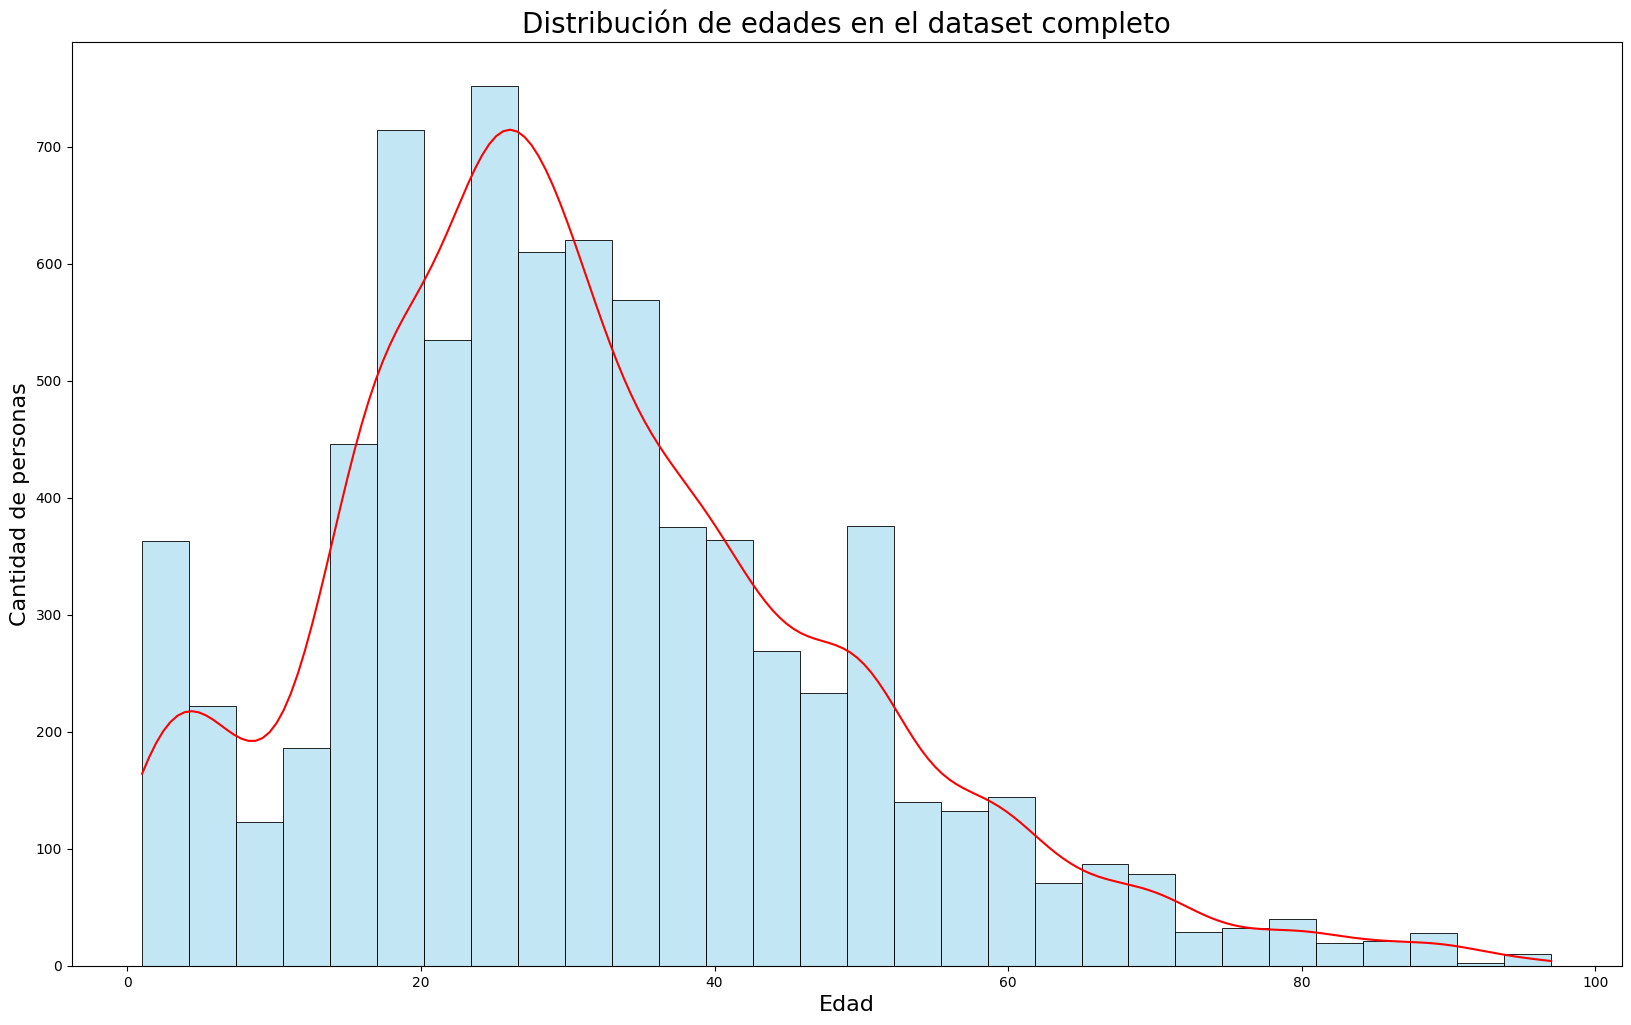

In [12]:
# Gráfica de edades
plt.figure(figsize=(20,12))
ax = sns.histplot(df['real_age'], bins=30, kde=True, color='skyblue', edgecolor='black', linewidth=0.6, alpha=0.5)
ax.lines[-1].set_color('red')
plt.title('Distribución de edades en el dataset completo', fontsize=20)
plt.xlabel('Edad', fontsize=16)
plt.ylabel('Cantidad de personas', fontsize=16)
plt.show()

Existe una distribución muy clara donde la mayoría de las persoans se encuentran en un rango de edad de 0 a +/- 52 años, y a partir de ese momento, existe una caída muy importante. Probablemente, a pesar de que la expectativa de vida es mucho mayor a este valor, las personas a partir de esta edad dejan de hacer las compras de manera aactiva.

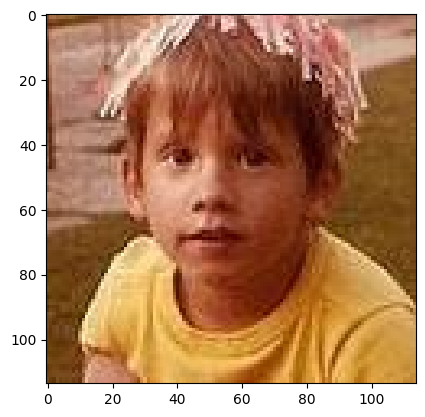

In [13]:
# Prueba de lectura de la primera imagen
image = Image.open('/content/drive/MyDrive/proyecto17/final_files/all/000000.jpg')
array = np.array(image)
plt.imshow(array)

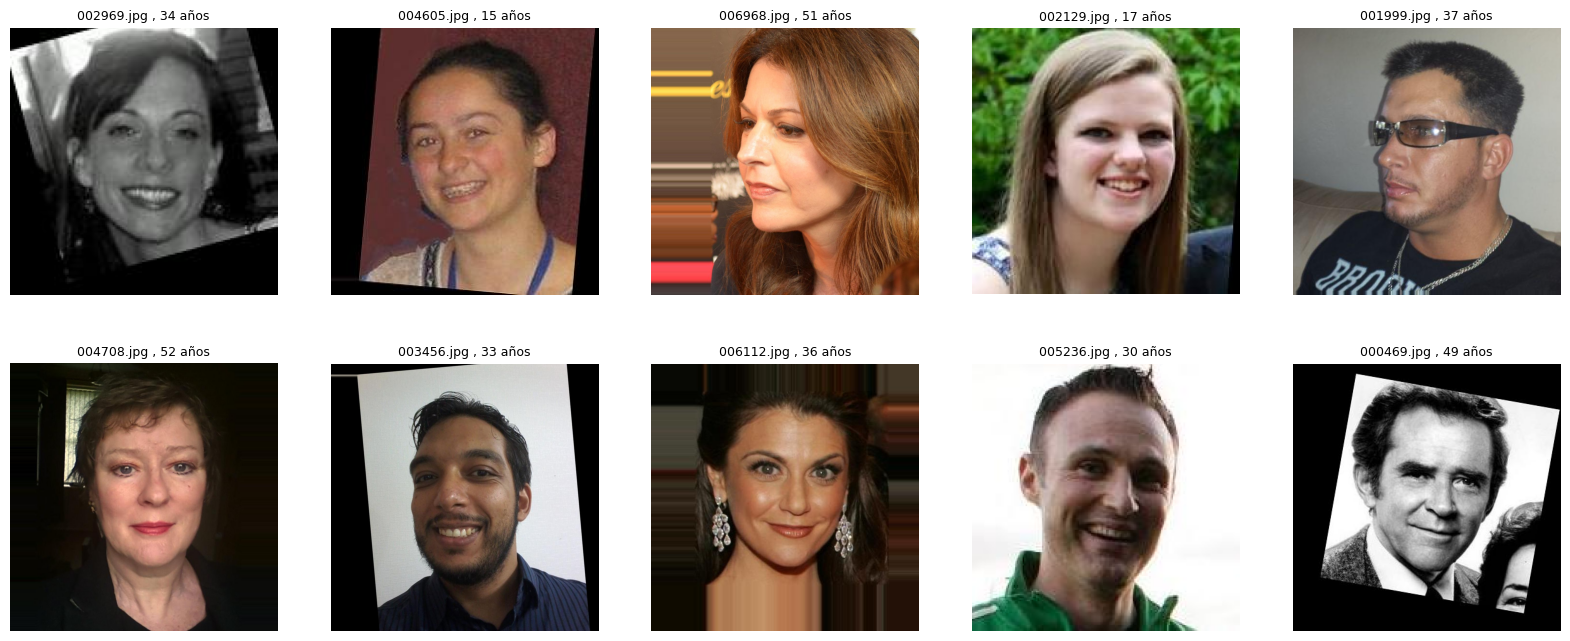

In [14]:
# Función para mostear 10 imágenes aleatorias
def show_random_images(df, k=10, img_dir=img_dir):
    sample = df.sample(n=k, random_state=None)
    cols = 5
    rows = (k + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()
    for ax, (_, row) in zip(axes, sample.iterrows()):
        path = os.path.join(img_dir, row['file_name'])
        img = Image.open(path).convert('RGB')
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{row['file_name']} , {row['real_age']} años", fontsize=9)
    plt.show()

show_random_images(df_train, k=10)

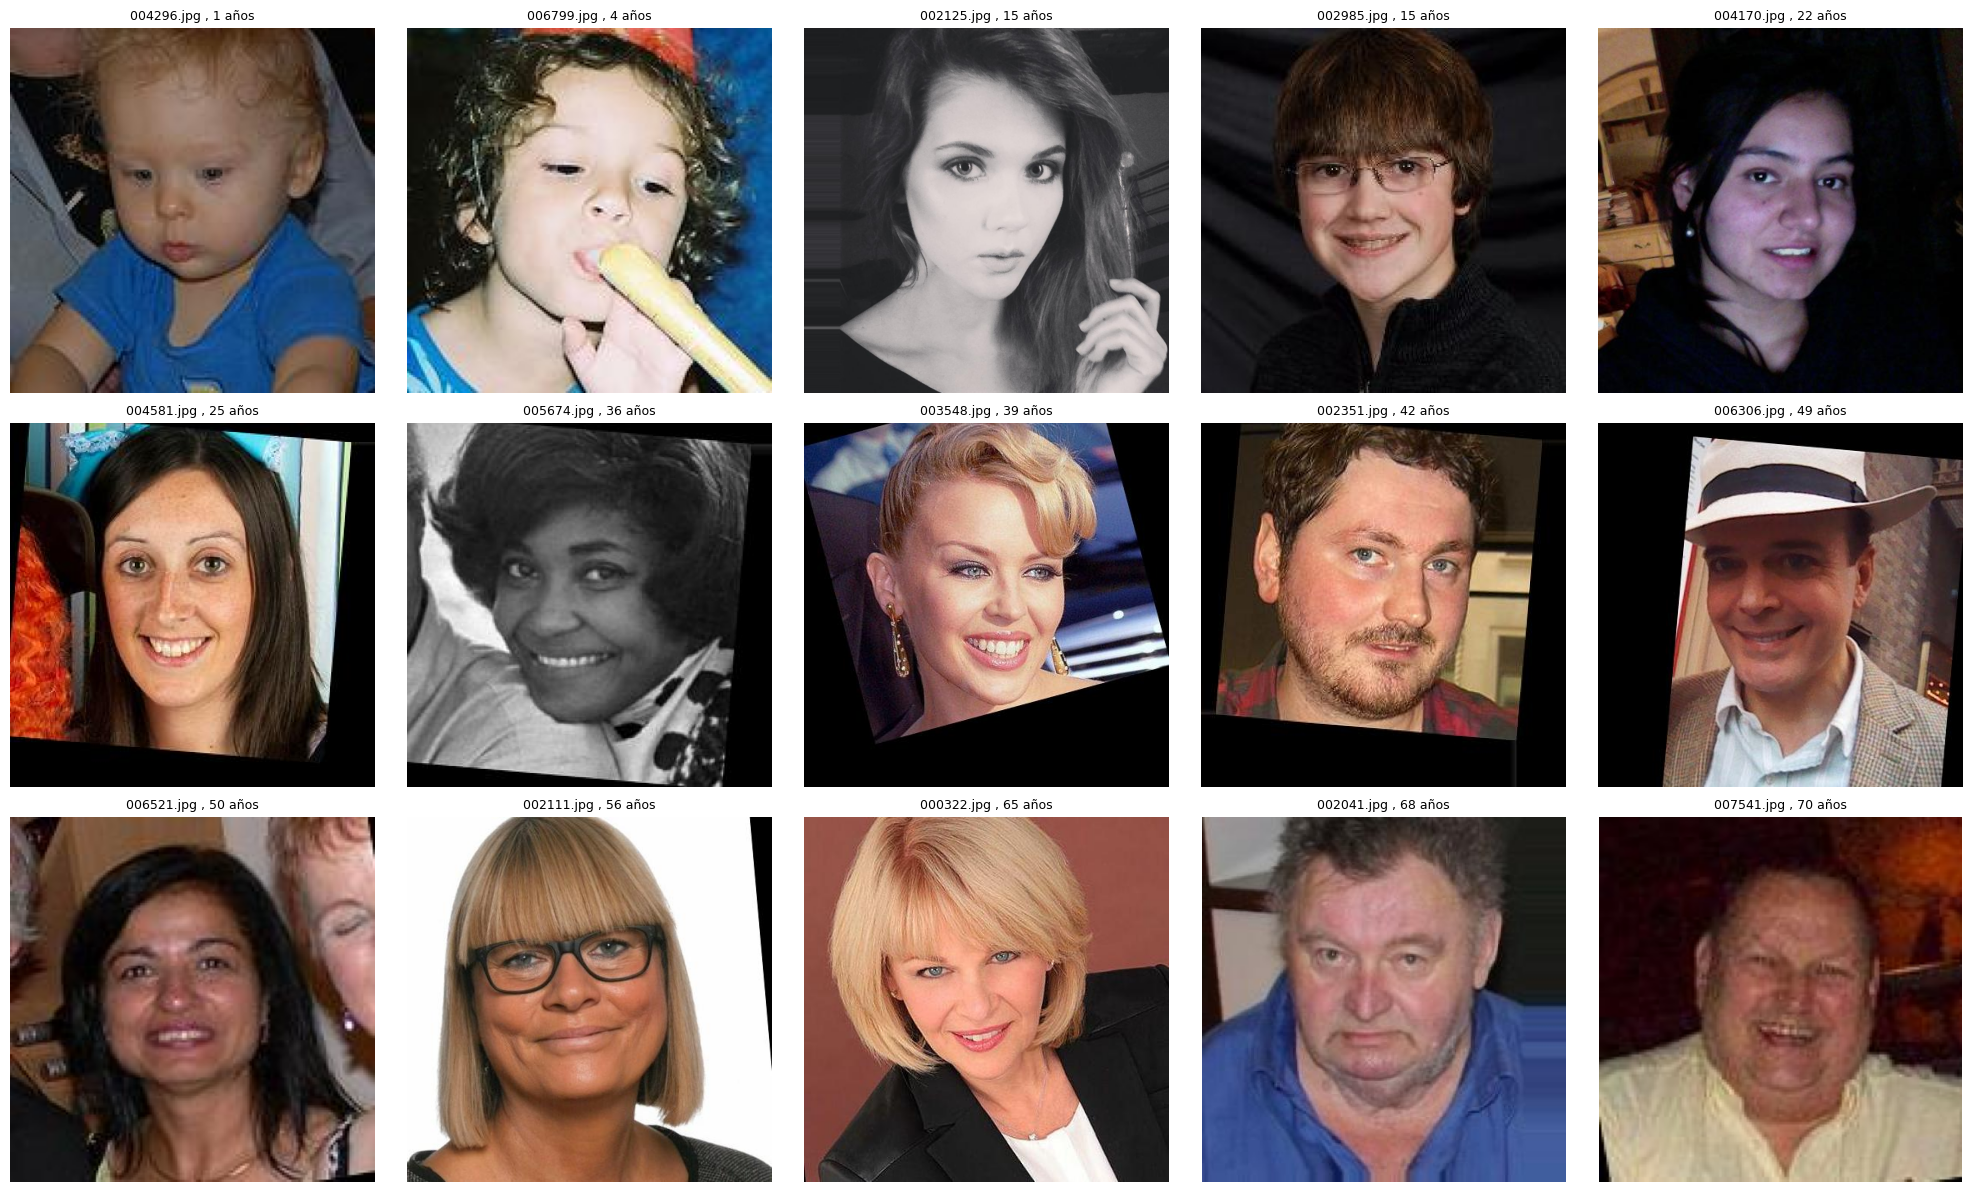

In [15]:
source = df_train
per_bin = 2
max_imgs = 15
per_bin = 2

def show_images_by_decade(df, img_dir=img_dir, per_bin=per_bin, max_imgs=max_imgs, seed=None):
    # Crear bins por décadas 0–9, 10–19, …, 110–119 (ajusta si tu rango es menor)
    bins = list(range(0, 121, 10))
    df = df.copy()
    df['age_bin'] = pd.cut(df['real_age'], bins=bins, right=False, include_lowest=True)

    # Muestrea por bin (estratificado): hasta 'per_bin' por década
    samples = []
    for bin_label, grp in df.groupby('age_bin', observed=True):
        if len(grp) == 0:
            continue
        take = min(per_bin, len(grp))
        samples.append(grp.sample(n=take, random_state=seed ))
    sel = pd.concat(samples).sort_values('real_age').head(max_imgs).reset_index(drop=True)

    # Plot en grilla
    k = len(sel)
    cols = 5
    rows = (k + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sel.iterrows()):
        path = os.path.join(img_dir, row['file_name'])
        try:
            img = Image.open(path).convert('RGB')
            ax.imshow(img)
            ax.set_title(f"{row['file_name']} , {row['real_age']} años", fontsize=9)
        except Exception:
            ax.text(0.5, 0.5, os.path.basename(path), ha='center', va='center')
        ax.axis('off')

    for ax in axes[k:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images_by_decade(source)

# Conclusión del preprocesamiento

Se hizo un preprocesamiento donde en primer lugar, se cargaron los datos del csv mediante métodos sencillos y convencionales, y también se cargaron los datos del banco de datos en formato de imágenes.

COmo hallazgos se obtuvo la siguiente información:

* El dataset tiene imágenes las cuales rompen el índice, sin embargo, esto es irrelevante para cuando se pretenda construir un modelo, el dataset es de excelente calidad, ya que no hay valores ni elementos nulos, duplicados implícita o explícitamente, etc.
* En cuanto a la distribución de los datos, en efecto hay una tendencia donde la mayoría de la gente tiene entre 0 y 41 años (el 75% de los datos está en este rango). La concentración de edades ≤ 41 sugiere que el modelo será mejor en jóvenes-adultos que en edades avanzadas.
* Existe un desbalance por edad (cola escasa >~60 años).

En el preprocesamiento de imágenes de utilizaron diferentes métodos con el propósito de hacer una aumentación y mejorar la calidad del modelo.

# Modelado

In [24]:
# Relu, 00001, 3 epochs, datos augmentados.
# FUncuión para cargar datos
def load_data_from_df(df, directory, img_size=(224, 224), batch_size=16, shuffle=True, seed=17):
    datagen = ImageDataGenerator(rescale=1./255)
    flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=shuffle,
        seed=seed,
        color_mode='rgb'
    )
    return flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.00001) # Learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=3):
    model.fit(
        train_data,
        validation_data=valid_datagen_flow,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        steps_per_epoch=None,
        validation_steps=None)

    return model

input_shape = (224, 224, 3)

# train = load_data_from_df(train_datagen_flow, '/content/drive/MyDrive/proyecto17/final_files/all/') # No Augmentados
# test = load_data_from_df(test_datagen_flow, '/content/drive/MyDrive/proyecto17/final_files/all/') # No Augmentados
train = train_datagen_flow
test = test_datagen_flow
model = create_model(input_shape)
model = train_model(model, train, test)

Epoch 1/3
332/332 - 558s - 2s/step - loss: 635.5502 - mae: 20.0227 - val_loss: 887.3704 - val_mae: 24.8494
Epoch 2/3
332/332 - 112s - 338ms/step - loss: 159.5981 - mae: 9.4789 - val_loss: 366.4795 - val_mae: 13.9866
Epoch 3/3
332/332 - 125s - 376ms/step - loss: 111.3687 - mae: 7.9728 - val_loss: 110.3250 - val_mae: 7.7714
No se alcanzó el resultado


In [22]:
# Relu, 00001, 10 epochs, datos sin augmentar
# FUncuión para cargar datos
def load_data_from_df(df, directory, img_size=(224, 224), batch_size=16, shuffle=True, seed=17):
    datagen = ImageDataGenerator(rescale=1./255)
    flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=shuffle,
        seed=seed,
        color_mode='rgb'
    )
    return flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.00001) # Learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        steps_per_epoch=None,
        validation_steps=None)

    return model

input_shape = (224, 224, 3)

train = load_data_from_df(df_train, '/content/drive/MyDrive/proyecto17/final_files/all/')
test = load_data_from_df(df_test, '/content/drive/MyDrive/proyecto17/final_files/all/')
model = create_model(input_shape)
model = train_model(model, train, test)

Found 5312 validated image filenames.
Found 1139 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


332/332 - 119s - 358ms/step - loss: 589.7529 - mae: 19.2350 - val_loss: 1261.7977 - val_mae: 31.0817
Epoch 2/10
332/332 - 65s - 195ms/step - loss: 128.0352 - mae: 8.4829 - val_loss: 321.4398 - val_mae: 13.1159
Epoch 3/10
332/332 - 64s - 192ms/step - loss: 69.8242 - mae: 6.3759 - val_loss: 144.5327 - val_mae: 8.7278
Epoch 4/10
332/332 - 66s - 200ms/step - loss: 48.3036 - mae: 5.3136 - val_loss: 103.9280 - val_mae: 7.7160
Epoch 5/10
332/332 - 63s - 189ms/step - loss: 36.7655 - mae: 4.7643 - val_loss: 109.8694 - val_mae: 7.8753
Epoch 6/10
332/332 - 66s - 200ms/step - loss: 36.5863 - mae: 4.6731 - val_loss: 101.7078 - val_mae: 7.5429
Epoch 7/10
332/332 - 63s - 189ms/step - loss: 31.3920 - mae: 4.3420 - val_loss: 100.5118 - val_mae: 7.4285
Epoch 8/10
332/332 - 62s - 186ms/step - loss: 29.1092 - mae: 4.1656 - val_loss: 97.5792 - val_mae: 7.3932
Epoch 9/10
332/332 - 62s - 185ms/step - loss: 28.3388 - mae: 4.1598 - val_loss: 93.2889 - val_mae: 7.3320
Epoch 10/10
332/332 - 62s - 188ms/step - lo

In [23]:
# Linear, 0001, 10 epochs, datos sin augmentar
# FUncuión para cargar datos
def load_data_from_df(df, directory, img_size=(224, 224), batch_size=16, shuffle=True, seed=17):
    datagen = ImageDataGenerator(rescale=1./255)
    flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=shuffle,
        seed=seed,
        color_mode='rgb'
    )
    return flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(learning_rate=0.0001) # Con este learning rate sí dió el resultado
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        steps_per_epoch=None,
        validation_steps=None)

    return model

input_shape = (224, 224, 3)

train = load_data_from_df(df_train, '/content/drive/MyDrive/proyecto17/final_files/all/')
test = load_data_from_df(df_test, '/content/drive/MyDrive/proyecto17/final_files/all/')
model = create_model(input_shape)
model = train_model(model, train, test)

Found 5312 validated image filenames.
Found 1139 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


332/332 - 118s - 357ms/step - loss: 193.0532 - mae: 10.1371 - val_loss: 896.8884 - val_mae: 24.9867
Epoch 2/10
332/332 - 62s - 188ms/step - loss: 73.7062 - mae: 6.5257 - val_loss: 232.4737 - val_mae: 11.4616
Epoch 3/10
332/332 - 62s - 187ms/step - loss: 42.6068 - mae: 5.0026 - val_loss: 100.3182 - val_mae: 7.4057
Epoch 4/10
332/332 - 63s - 190ms/step - loss: 29.0316 - mae: 4.1409 - val_loss: 111.3382 - val_mae: 7.8424
Epoch 5/10
332/332 - 63s - 190ms/step - loss: 22.0231 - mae: 3.6157 - val_loss: 77.2062 - val_mae: 6.6477
Epoch 6/10
332/332 - 63s - 190ms/step - loss: 22.6715 - mae: 3.6687 - val_loss: 100.3490 - val_mae: 7.7739
Epoch 7/10
332/332 - 62s - 188ms/step - loss: 19.5253 - mae: 3.4060 - val_loss: 79.8156 - val_mae: 6.7066
Epoch 8/10
332/332 - 83s - 249ms/step - loss: 13.9847 - mae: 2.8618 - val_loss: 70.3809 - val_mae: 6.3127
Epoch 9/10
332/332 - 62s - 188ms/step - loss: 13.3208 - mae: 2.7905 - val_loss: 81.3152 - val_mae: 6.7349
Epoch 10/10
332/332 - 67s - 201ms/step - loss: 

## Conclusiones

Se hizo una carga de datos de un CSV, el cual tenía una muy buena calidad, simplemente se hizo un cambio de índice y por momentos, se usaron bins para hacer un split de entrenamiento, validación y prueba que esutiveran balanceados. Este contiene información del nombre del archivo (la foto de la persona) y su edad.

Se hizo la carga de las imágenes por un ImageDataGenerator,  en donde se hizo una augmentación para las imágenes de entrenamiento y se hizo una reescalado como normalización para las imágenes de los 3 dataframes. Al ser un problema de regresión y no tener el material compacto, se hizo uso de diferentes metologías como el flow_from_dataset y ajuste de parámetros (como raw para las clases).

Se hizo un EDA muy sencillo, por la naturaleza del DF. Existe una distribución muy clara donde la mayoría de las persoans se encuentran en un rango de edad de 0 a +/- 52 años, y a partir de ese momento, existe una caída muy importante. Probablemente, a pesar de que la expectativa de vida es mucho mayor a este valor, las personas a partir de esta edad dejan de hacer las compras de manera activa.

Se construyeron un par de funciones para obtener de manera aleatoria, una muestra de las personas, y otra donde según un rango de edades, podríamos ver el contraste de las personas.

Para la construcción del modelo se utilizó una arquitectura ResNet50. Se hicieron 3 pruebas con diferentes resultados. Al princpio se corrió un modelo el cual utilizó los datos augmentados, una función de activación Relu, un optimizador Adam con una tasa de aprendizaje de 0.00001 y un modelo que diera 3 epochs. Para las tres epochs de el primer modelo, la mae bajó de 20.02 a 7.97 para el set de entrenamiento, mientras que, para el set de test bajó de 24.80 a 7.77, técnicamente este valor ya cumple con los requisitos, pero se explorarán más posibilidades, esto nos sugiere que aquí, probablemente, la augmentación sirvió mucho, ya que cuando el train lleva augmentación y val/test no → el modelo “ve” ejemplos más difíciles en train, por eso mae_train > mae_val.

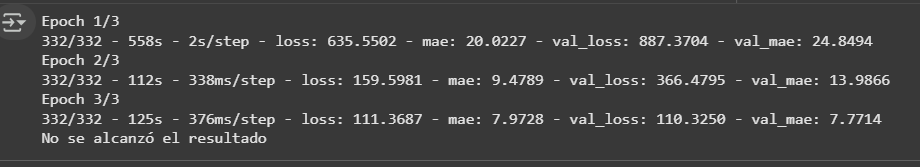

Para el segundo modelo, no se utilizaron los datos augmentados, se usó una función de actuvación relu, con un Adam de learning rate de 0.00001, y un modelo que diera 10 epochs. Aquí fue donde se alcanzaron los resultados esperados. Para el cuarto epoch la Mae de las imágenes de entrenamiento bajaron de 19.23 a 5.31, lo que nos indica que el modelo sí aprendió y para el dataset de prueba, en 7.71, y a partir de aquí se puede notar un sobreaujste, ya que la mae para el entrenamiento sigue bajando pero para el test, sube.

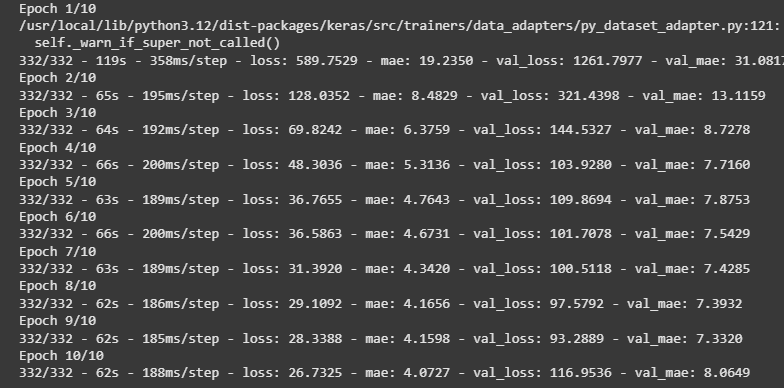

Finalmente se hizo un modelo el cual cambiara un poco más los parámemtros del modelo, donde se usó  una función de activación linear, el adam de tasa de aprendizaje de 0.0001, y un modelo de 10 epochs, todo esto, con los datos sin augmentar. En este caso, la mae cayó a lo largo del modelo de un valor de 10.13 hasta un 2.65, sin embargo, fue hasta la tercera epoch donde se alcanzó el objetivo, cuándo la mae de entrenamiento tenía un valor de 5 y el de test de 7.40, sin embargo, es notorio que como en el modelo anterior, existe un sobreajuste, ya que la mae de test tiene fluctuaciones con valores de 7.8 a 6.2 mientras que en el entrenamiento únicamente baja.

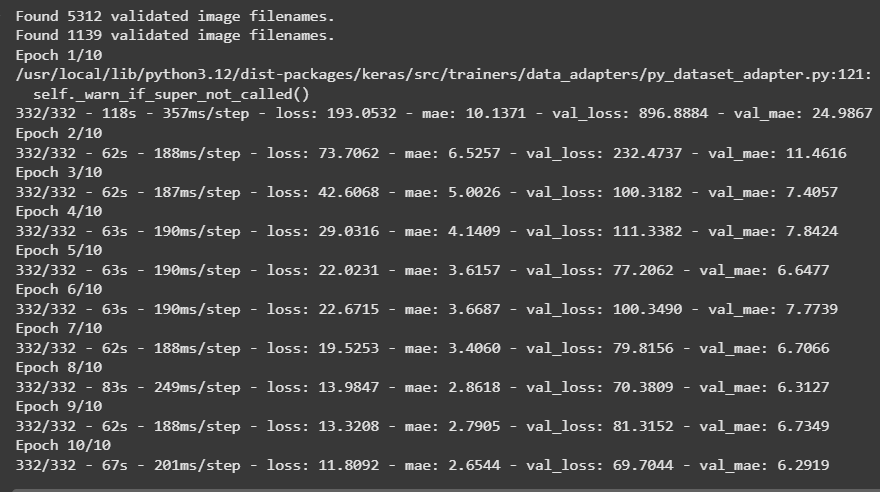


En este caso, computer vision a mi criterio es deficiente para lograr la tarea. A pesar de que se obtuvo una mae por debajo del valor que se requería, considero que sigue existiendo un margen de "error" que puede que no sea muy grande o significativo para la tarea de regresión del cálculo de ciertas edades, sin embargo, la tienda no puede arriesgarse a venderle alcohol a personas menores de edad, y probablemente esta metodología no pueda disernir muy bien a una personas de, ejemplo 17 años, que pretenda comprar alcohol ilegalmente.

El área de computer vision puede resultar más útil, sensible y aplicativa en otros escenarios, o cuando por ejemplo, se tenga un problema de clasificación donde las clases estén bien definidas.